In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import os
import json
import requests
from datetime import datetime
from pathlib import Path

class Weather:
    BASE_URL = "https://power.larc.nasa.gov/api/temporal/hourly/point"

    def __init__(self, city, lat, lon, cache_dir="weather_cache"):
        self.city = city.replace(" ", "_")
        self.lat = lat
        self.lon = lon
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)

        self._loaded_year = None
        self._year_data = None

    # -------------------------------------------------
    # Cache utilities
    # -------------------------------------------------

    def _cache_path(self, year):
        return self.cache_dir / f"{self.city}_{year}.json"

    def _cache_valid(self, year):
        """
        Validates if cache exists AND contains enough hourly entries.
        A full year should have ~8760 hours.
        """
        path = self._cache_path(year)
        if not path.exists():
            return False

        try:
            with open(path, "r") as f:
                data = json.load(f)
            # minimal sanity check
            return len(data) > 8000
        except Exception:
            return False

    # -------------------------------------------------
    # Download NASA POWER
    # -------------------------------------------------

    def _download_year(self, year):
        print(f"[Weather] Downloading NASA POWER data for {self.city} {year}...")

        params = {
            "parameters": "ALLSKY_SFC_SW_DWN,T2M",
            "community": "RE",
            "longitude": self.lon,
            "latitude": self.lat,
            "start": f"{year}0101",
            "end": f"{year}1231",
            "format": "JSON"
        }

        r = requests.get(self.BASE_URL, params=params, timeout=120)
        r.raise_for_status()

        raw = r.json()

        ghi_data = raw["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"]
        temp_data = raw["properties"]["parameter"]["T2M"]

        # Flatten structure for fast lookup
        processed = {}
        for key in ghi_data.keys():
            processed[key] = {
                "ghi": ghi_data[key],
                "temp": temp_data[key]
            }

        # Save to cache
        with open(self._cache_path(year), "w") as f:
            json.dump(processed, f)

        print(f"[Weather] Cached {len(processed)} hourly entries")

    # -------------------------------------------------
    # Loading
    # -------------------------------------------------

    def _ensure_year_loaded(self, year):
        if self._loaded_year == year:
            return

        if not self._cache_valid(year):
            self._download_year(year)

        with open(self._cache_path(year), "r") as f:
            self._year_data = json.load(f)

        self._loaded_year = year

    # -------------------------------------------------
    # Public API
    # -------------------------------------------------

    def get_weather(self, dt: datetime):
        """
        Returns: (temperature °C, GHI W/m²)
        """

        year = dt.year
        self._ensure_year_loaded(year)

        key = dt.strftime("%Y%m%d%H")

        if key not in self._year_data:
            # rare missing hour — fallback to nearest
            hour_back = dt.replace(hour=max(dt.hour-1, 0))
            key = hour_back.strftime("%Y%m%d%H")

        entry = self._year_data[key]
        return entry["temp"], entry["ghi"]


In [18]:
weather = Weather("Delhi", 28.6139, 77.2090)

In [27]:
temp, ghi = [], []
for hour in range(24):
    t, g = weather.get_weather(datetime(2023, 1, 1, hour))
    temp.append(t)
    ghi.append(g)



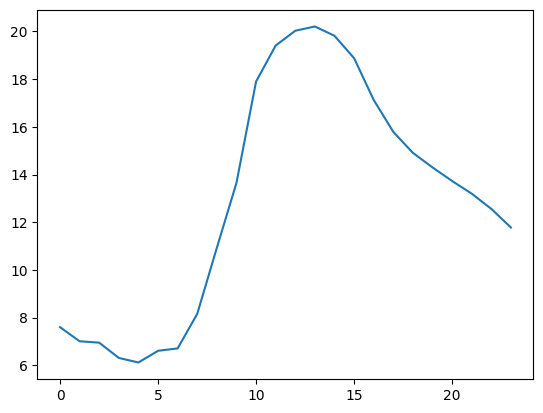

In [36]:
plt.plot(np.array([hour for hour in range(0,24)]), temp)

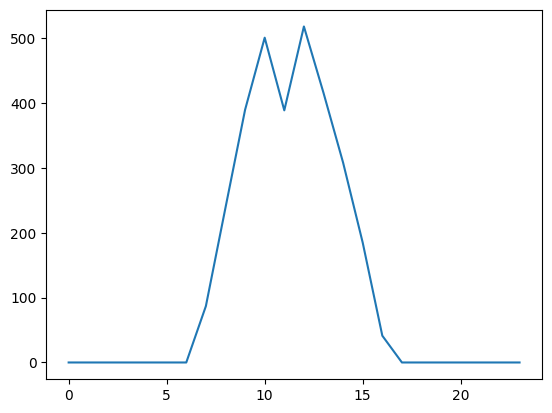

In [37]:

plt.plot(np.array([hour for hour in range(0,24)]), ghi)

In [1]:
from pathlib import Path
import json

In [2]:
path =Path(r'C:\Users\Abhyuday Chauhan\projects\FY_project\tests\src\weather_cache\Bangalore_2024.json') 

In [3]:
with open(path, "r") as f:
    data = json.load(f)

In [ ]:
sum = 0
count = 0
max = 0
for key, value in data.items():
    if value["ghi"] > max:
        max = value["ghi"]
    sum += value["ghi"]
    count += 1
print(f"Average GHI: {sum/count:.2f} W/m², Max GHI: {max}")

Average GHI: 215.53 W/m², Max GHI: 1070.35 W/m²
